In [1]:
import pydub
import pandas as pd
import librosa as lb
import numpy as np
import os
import random
from linetimer import CodeTimer

In [2]:
def osPath(path):
    return os.path.abspath(path)

In [3]:
pathname = "data/data files/validated.tsv"
output_pathname = "data/data files/validated_SpeechFeatures.tsv"
os.environ["PATH"] += os.pathsep + 'FFMPEG/bin'
mp3_folder = "data/clips"
wav_folder = "data/wav_clips"

# Feature Extraction

In [4]:
df = pd.read_csv(pathname, sep="\t")
df

,client_id,path,sentence,up_votes,down_votes,age,gender,accent
0,0013037a1d45cc33460806cc3f8ecee9d536c45639ba4c...,common_voice_en_699711.mp3,She'll be all right.,2,1,NaN,NaN,NaN
1,003fb666a99eb3aa3ba05d9c8641c18e55cf7d34d1b981...,common_voice_en_17263741.mp3,Do you mean it?,2,0,NaN,NaN,NaN
2,0047f1aea3f39c4c6a9298d84f046c1f84f439f594d840...,common_voice_en_17561821.mp3,How is Mozilla going to handle ambiguities lik...,2,0,NaN,NaN,NaN
3,00610bda27826b8615139e6a430d43382935f37922dc1c...,common_voice_en_59751.mp3,I guess you must think I'm kinda batty.,2,1,NaN,NaN,NaN
4,007762ba618b38ed77739616c7a6ace0341e1e134ac405...,common_voice_en_18902772.mp3,Groves started writing songs when she was four...,2,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
644114,939991dfcf12d8250739f3b4e5ed47e0dc4bf8ffb69810...,common_voice_en_18792608.mp3,It is almost exclusively in the final version ...,2,1,twenties,male,NaN
644115,939991dfcf12d8250739f3b4e5ed47e0dc4bf8ffb69810...,common_voice_en_18792609.mp3,All songs written by Mark Greaney.,2,0,twenties,male,NaN
644116,939991dfcf12d8250739f3b4e5ed47e0dc4bf8ffb69810...,common_voice_en_18792611.mp3,Later the ninth and tenth grades were added.,2,1,twenties,male,NaN
644117,939991dfcf12d8250739f3b4e5ed47e0dc4bf8ffb69810...,common_voice_en_18792612.mp3,"Aull, who named it Quasi-Rolle theorem.",2,1,twenties,male,NaN


In [5]:
df = df.dropna(subset=["age","gender","accent"]) # This will DEFINITELY lead to a smaller sample size and less reliable results, but for simplicity's and comparison's sake, let's only go with the data that also includes accents and ages.

# df = df[df.gender != "other"] # Let's not remove these right away. We can run an experiment on whether models are affected by this or not.

df = df[["up_votes","down_votes","path", "age", "gender","accent"]] # Might be a good idea to keep up_votes nad down_votes as well, so I added these.

df

,up_votes,down_votes,path,age,gender,accent
8,2,0,common_voice_en_18489793.mp3,thirties,male,us
11,2,0,common_voice_en_17779714.mp3,thirties,male,canada
40,2,1,common_voice_en_125399.mp3,seventies,female,england
44,2,1,common_voice_en_18274221.mp3,twenties,male,us
54,2,0,common_voice_en_17147389.mp3,twenties,male,us
...,...,...,...,...,...,...
638031,2,0,common_voice_en_18829416.mp3,sixties,male,us
638032,2,0,common_voice_en_18829417.mp3,sixties,male,us
638033,2,0,common_voice_en_18829418.mp3,sixties,male,us
638034,2,0,common_voice_en_18829419.mp3,sixties,male,us


In [6]:
# New Columns
column_chroma_stft = [] #chromagram https://en.wikipedia.org/wiki/Chroma_feature
column_rms = [] #root mean square https://en.wikipedia.org/wiki/Root_mean_square#In_common_waveforms
column_spec_cent = [] #spectral centroid https://en.wikipedia.org/wiki/Spectral_centroid
column_spec_bw = [] #spectral bandwidth https://en.wikipedia.org/wiki/Bandwidth_(signal_processing)#x_dB_bandwidth
column_rolloff = [] #spectral roll-off https://en.wikipedia.org/wiki/Roll-off
column_zcr = [] #zero-crossing rate https://en.wikipedia.org/wiki/Zero-crossing_rate
column_mfcc1 = [] #Mel-frequency cepstrum coefficients https://en.wikipedia.org/wiki/Mel-frequency_cepstrum
column_mfcc2 = []
column_mfcc3 = []
column_mfcc4 = []
column_mfcc5 = []
column_mfcc6 = []
column_mfcc7 = []
column_mfcc8 = []
column_mfcc9 = []
column_mfcc10 = []
column_mfcc11 = []
column_mfcc12 = []
column_mfcc13 = []
column_mfcc14 = []
column_mfcc15 = []
column_mfcc16 = []
column_mfcc17 = []
column_mfcc18 = []
column_mfcc19 = []
column_mfcc20 = []

In [7]:
# Get all audio file paths and names
wav_FilePaths = []
mp3_FileNames = []
dir = os.fsdecode(wav_folder)
for path in os.listdir(dir):
    src = os.path.join(dir, path)
    name = path[:-3] + str("mp3")
    wav_FilePaths.append(src)
    mp3_FileNames.append(name)

In [8]:
# Remove all entries from dataframe where we don't have the given audio file
df = df[df["path"].isin(mp3_FileNames)]
dictionary = dict(zip(mp3_FileNames, wav_FilePaths))
df["path"] = df["path"].map(dictionary)

C:\Users\Frederik\Anaconda3\envs\Py3_IDS\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [9]:
df

,up_votes,down_votes,path,age,gender,accent
40,2,1,data/wav_clips\common_voice_en_125399.wav,seventies,female,england
199,2,0,data/wav_clips\common_voice_en_1100186.wav,sixties,male,african
219,2,0,data/wav_clips\common_voice_en_1272597.wav,twenties,male,indian
396,2,0,data/wav_clips\common_voice_en_18354220.wav,twenties,female,england
611,2,0,data/wav_clips\common_voice_en_15734801.wav,fourties,male,scotland
...,...,...,...,...,...,...
637541,2,0,data/wav_clips\common_voice_en_18819172.wav,sixties,male,us
637545,2,0,data/wav_clips\common_voice_en_18819186.wav,sixties,male,us
637627,2,0,data/wav_clips\common_voice_en_18819325.wav,sixties,male,us
637745,2,0,data/wav_clips\common_voice_en_18822358.wav,sixties,male,us


In [10]:
# Get speech features, add them to the dataframe and export to csv file
for index, row in df.iterrows():
    y, sr = lb.load(osPath(row.path))

    chroma_stft = np.mean(lb.feature.chroma_stft(y=y, sr=sr))
    #https://librosa.github.io/librosa/generated/librosa.feature.chroma_stft.html
    rms = np.mean(lb.feature.rms(y=y))
    #https://librosa.github.io/librosa/generated/librosa.feature.rms.html
    spec_cent = np.mean(lb.feature.spectral_centroid(y=y, sr=sr))
    #https://librosa.github.io/librosa/generated/librosa.feature.spectral_centroid.html
    spec_bw = np.mean(lb.feature.spectral_bandwidth(y=y, sr=sr))
    #https://librosa.github.io/librosa/generated/librosa.feature.spectral_bandwidth.html
    rolloff = np.mean(lb.feature.spectral_rolloff(y=y, sr=sr))
    #https://librosa.github.io/librosa/generated/librosa.feature.spectral_rolloff.html
    zcr = np.mean(lb.feature.zero_crossing_rate(y))
    #https://librosa.github.io/librosa/generated/librosa.feature.zero_crossing_rate.html
    mfcc = lb.feature.mfcc(y=y, sr=sr)
    #https://librosa.github.io/librosa/generated/librosa.feature.mfcc.html

    column_chroma_stft.append(chroma_stft)
    column_rms.append(rms)
    column_spec_cent.append(spec_cent)
    column_spec_bw.append(spec_bw)
    column_rolloff.append(rolloff)
    column_zcr.append(zcr)

    column_mfcc1.append(np.mean(mfcc[0]))
    column_mfcc2.append(np.mean(mfcc[1]))
    column_mfcc3.append(np.mean(mfcc[2]))
    column_mfcc4.append(np.mean(mfcc[3]))
    column_mfcc5.append(np.mean(mfcc[4]))
    column_mfcc6.append(np.mean(mfcc[5]))
    column_mfcc7.append(np.mean(mfcc[6]))
    column_mfcc8.append(np.mean(mfcc[7]))
    column_mfcc9.append(np.mean(mfcc[8]))
    column_mfcc10.append(np.mean(mfcc[9]))
    column_mfcc11.append(np.mean(mfcc[10]))
    column_mfcc12.append(np.mean(mfcc[11]))
    column_mfcc13.append(np.mean(mfcc[12]))
    column_mfcc14.append(np.mean(mfcc[13]))
    column_mfcc15.append(np.mean(mfcc[14]))
    column_mfcc16.append(np.mean(mfcc[15]))
    column_mfcc17.append(np.mean(mfcc[16]))
    column_mfcc18.append(np.mean(mfcc[17]))
    column_mfcc19.append(np.mean(mfcc[18]))
    column_mfcc20.append(np.mean(mfcc[19]))

In [11]:
# Add columns to dataframe
df = df.assign(chroma_stft=column_chroma_stft)
df = df.assign(rms=column_rms)
df = df.assign(spec_cent=column_spec_cent)
df = df.assign(spec_bw=column_spec_bw)
df = df.assign(rolloff=column_rolloff)
df = df.assign(zcr=column_zcr)

df = df.assign(mfcc1=column_mfcc1)
df = df.assign(mfcc2=column_mfcc2)
df = df.assign(mfcc3=column_mfcc3)
df = df.assign(mfcc4=column_mfcc4)
df = df.assign(mfcc5=column_mfcc5)
df = df.assign(mfcc6=column_mfcc6)
df = df.assign(mfcc7=column_mfcc7)
df = df.assign(mfcc8=column_mfcc8)
df = df.assign(mfcc9=column_mfcc9)
df = df.assign(mfcc10=column_mfcc10)
df = df.assign(mfcc11=column_mfcc11)
df = df.assign(mfcc12=column_mfcc12)
df = df.assign(mfcc13=column_mfcc13)
df = df.assign(mfcc14=column_mfcc14)
df = df.assign(mfcc15=column_mfcc15)
df = df.assign(mfcc16=column_mfcc16)
df = df.assign(mfcc17=column_mfcc17)
df = df.assign(mfcc18=column_mfcc18)
df = df.assign(mfcc19=column_mfcc19)
df = df.assign(mfcc20=column_mfcc20)

In [12]:
df.to_csv(output_pathname, encoding="utf-8", sep="\t", index=False)

In [13]:
df

,up_votes,down_votes,path,age,gender,accent,chroma_stft,rms,spec_cent,spec_bw,...,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20
40,2,1,data/wav_clips\common_voice_en_125399.wav,seventies,female,england,0.365858,0.115715,749.461161,1098.897685,...,-2.856971,-3.027623,-4.218188,-3.524858,-2.171703,-3.582045,-6.109649,-4.734843,-3.389881,-3.896086
199,2,0,data/wav_clips\common_voice_en_1100186.wav,sixties,male,african,0.410334,0.040648,2267.620595,2404.396326,...,-10.669424,-1.874942,-4.879779,-1.593734,-4.482958,-0.079174,-7.289438,0.110350,-5.070335,-0.253545
219,2,0,data/wav_clips\common_voice_en_1272597.wav,twenties,male,indian,0.345455,0.031659,1612.923649,1703.784527,...,-11.175241,12.403630,-0.707115,-10.989146,5.282956,-4.065197,-13.469048,-0.858188,-6.580098,-0.527497
396,2,0,data/wav_clips\common_voice_en_18354220.wav,twenties,female,england,0.321885,0.049650,2182.273597,1690.673251,...,-8.489103,-15.566792,-8.552410,-6.938752,-7.111887,-12.982553,-5.543273,-2.269802,-9.797567,-0.697005
611,2,0,data/wav_clips\common_voice_en_15734801.wav,fourties,male,scotland,0.432749,0.019544,2456.893685,2577.651628,...,-6.922030,4.514844,-8.474165,3.093559,-5.899485,3.682870,-0.608785,-0.272467,-4.542766,2.137483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
637541,2,0,data/wav_clips\common_voice_en_18819172.wav,sixties,male,us,0.452195,0.068775,2612.592851,1936.058494,...,-7.232781,-4.111032,-6.217436,-1.402802,2.498643,-2.035199,-1.859134,-0.168663,-3.004894,3.106332
637545,2,0,data/wav_clips\common_voice_en_18819186.wav,sixties,male,us,0.465885,0.072035,2433.986338,1880.403386,...,-10.912062,-7.812710,-4.335599,-3.157963,1.017951,-3.971588,-2.111831,0.590116,-2.986250,5.327380
637627,2,0,data/wav_clips\common_voice_en_18819325.wav,sixties,male,us,0.496139,0.059773,2899.861998,2069.013057,...,-4.796014,-2.736257,-6.262944,-1.107921,2.475584,-0.847767,-0.785974,0.889395,-2.978726,2.341992
637745,2,0,data/wav_clips\common_voice_en_18822358.wav,sixties,male,us,0.490005,0.055018,2259.298682,1915.028359,...,-16.130146,1.807398,-6.351277,-4.038036,6.428793,-10.838871,1.197704,1.194029,-5.797193,6.492839


# Unsure we're handling some features correctly
## Or what does it mean to take means

In [71]:
from matplotlib import pyplot as plt
import pydub
from pydub import AudioSegment
from pydub.playback import play
import pandas as pd
import librosa as lb
import librosa.display
import numpy as np
import os

In [72]:
def librosaFeatureDisplay(feature,title):
    lb.display.specshow(feature)
    plt.title(title)
    plt.show()
    print("mean",np.mean(feature))
    print("standard deviation",np.std(feature))

In [77]:
df = pd.read_csv(output_pathname, encoding="utf-8", sep="\t")
df

,up_votes,down_votes,path,age,gender,accent,chroma_stft,rms,spec_cent,spec_bw,...,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20
0,2,0,data/wav_clips\common_voice_en_18354220.wav,twenties,female,england,0.321885,0.049650,2182.273597,1690.673251,...,-8.489103,-15.566792,-8.552410,-6.938752,-7.111887,-12.982553,-5.543273,-2.269802,-9.797567,-0.697005
1,2,1,data/wav_clips\common_voice_en_15757435.wav,twenties,male,england,0.344349,0.023608,1704.812968,1561.461615,...,-3.286148,-15.202602,-0.001332,-4.360271,-1.195109,1.533718,-9.492474,-4.393444,-9.174904,-12.035255
2,2,0,data/wav_clips\common_voice_en_17507716.wav,teens,female,other,0.269595,0.114961,1785.720819,1554.137874,...,-12.025450,-6.061091,-5.963960,-0.858532,-12.246932,-4.106375,-6.313654,-9.611370,-1.317794,-9.443284
3,2,0,data/wav_clips\common_voice_en_11693098.wav,twenties,male,us,0.368417,0.046559,2731.939926,2314.386144,...,-1.724111,-1.229390,-13.832965,3.033947,-9.902058,-6.078618,-6.369515,-6.008799,-1.032389,-7.903069
4,2,0,data/wav_clips\common_voice_en_10091129.wav,fifties,male,us,0.470616,0.024861,2201.567600,2078.750878,...,-3.009606,-0.709725,0.519248,-0.080496,2.776139,-0.070696,0.796693,1.269406,-3.660879,1.090581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5381,2,0,data/wav_clips\common_voice_en_18819172.wav,sixties,male,us,0.452195,0.068775,2612.592851,1936.058494,...,-7.232781,-4.111032,-6.217436,-1.402802,2.498643,-2.035199,-1.859134,-0.168663,-3.004894,3.106332
5382,2,0,data/wav_clips\common_voice_en_18819186.wav,sixties,male,us,0.465885,0.072035,2433.986338,1880.403386,...,-10.912062,-7.812710,-4.335599,-3.157963,1.017951,-3.971588,-2.111831,0.590116,-2.986250,5.327380
5383,2,0,data/wav_clips\common_voice_en_18819325.wav,sixties,male,us,0.496139,0.059773,2899.861998,2069.013057,...,-4.796014,-2.736257,-6.262944,-1.107921,2.475584,-0.847767,-0.785974,0.889395,-2.978726,2.341992
5384,2,0,data/wav_clips\common_voice_en_18822358.wav,sixties,male,us,0.490005,0.055018,2259.298682,1915.028359,...,-16.130146,1.807398,-6.351277,-4.038036,6.428793,-10.838871,1.197704,1.194029,-5.797193,6.492839


In [78]:
def present_values(row):
    y, sr = lb.load(osPath(row.path))
    lb.display.waveplot(y=y, sr=sr)
    plt.title(row.path)
    plt.show()
    print(row.path)
    librosaFeatureDisplay(lb.feature.chroma_stft(y=y, sr=sr),"Chromagram")
    librosaFeatureDisplay(lb.feature.rms(y=y),"Root Mean Square")
    librosaFeatureDisplay(lb.feature.spectral_centroid(y=y, sr=sr),"Spectral Centroid")
    librosaFeatureDisplay(lb.feature.spectral_bandwidth(y=y, sr=sr),"Spectral Bandwidth")
    librosaFeatureDisplay(lb.feature.spectral_rolloff(y=y, sr=sr),"Spectral Rolloff")
    librosaFeatureDisplay(lb.feature.zero_crossing_rate(y),"Zero-Crossing Rate")
    librosaFeatureDisplay(lb.feature.mfcc(y=y, sr=sr),"Mel-Frequency Ceptral Coefficient")

In [79]:
def play_sound(row):
    print("DOESN'T WORK")
    play(AudioSegment.from_wav(osPath(row.path)))

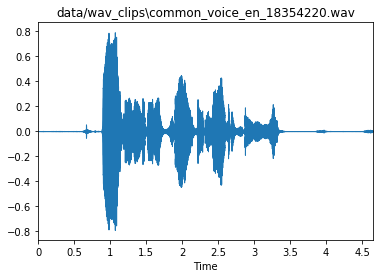

data/wav_clips\common_voice_en_18354220.wav


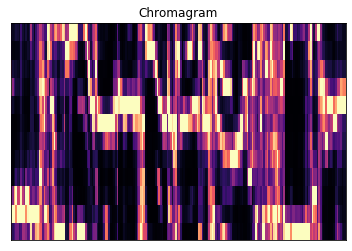

mean 0.32188508
standard deviation 0.32220516


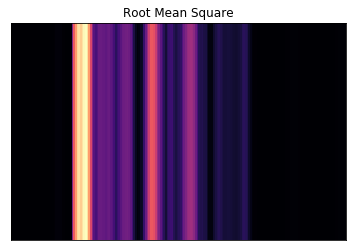

mean 0.049649514
standard deviation 0.071305335


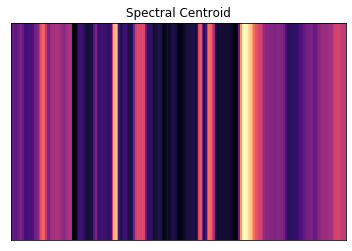

mean 2182.2735971796183
standard deviation 1256.5220340843643


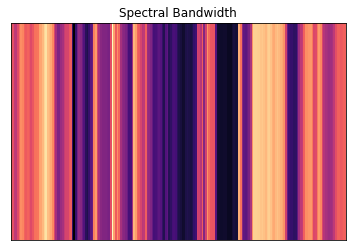

mean 1690.6732508558334
standard deviation 634.1430690052849


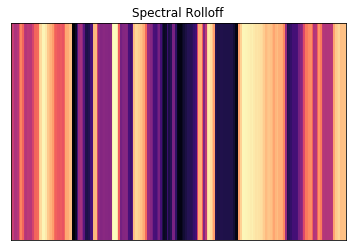

mean 3858.0322265625
standard deviation 2011.475348802791


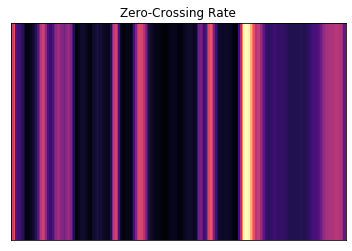

mean 0.14682932991293532
standard deviation 0.11118617681317494


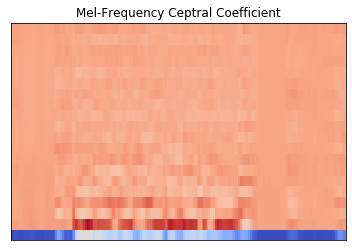

mean -21.812998
standard deviation 93.84438


In [80]:
present_values(df.iloc[0,:])

In [81]:
play_sound(df.iloc[1,:])

DOESN'T WORK


PermissionError: [Errno 13] Permission denied: 'C:\\Users\\Frederik\\AppData\\Local\\Temp\\tmpdiqbkg5p.wav'

# Modelling

In [77]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
plt.style.use('ggplot')

In [5]:
df = pd.read_csv(output_pathname, encoding="utf-8", sep="\t")
df

,up_votes,down_votes,path,age,gender,accent,chroma_stft,rms,spec_cent,spec_bw,...,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20
0,2,1,data/wav_clips\common_voice_en_125399.wav,seventies,female,england,0.365858,0.115715,749.461161,1098.897685,...,-2.856971,-3.027623,-4.218188,-3.524858,-2.171703,-3.582045,-6.109649,-4.734843,-3.389881,-3.896086
1,2,0,data/wav_clips\common_voice_en_1100186.wav,sixties,male,african,0.410334,0.040648,2267.620595,2404.396326,...,-10.669424,-1.874942,-4.879779,-1.593734,-4.482958,-0.079174,-7.289438,0.110350,-5.070335,-0.253545
2,2,0,data/wav_clips\common_voice_en_1272597.wav,twenties,male,indian,0.345455,0.031659,1612.923649,1703.784527,...,-11.175241,12.403630,-0.707115,-10.989146,5.282956,-4.065197,-13.469048,-0.858188,-6.580098,-0.527497
3,2,0,data/wav_clips\common_voice_en_18354220.wav,twenties,female,england,0.321885,0.049650,2182.273597,1690.673251,...,-8.489103,-15.566792,-8.552410,-6.938752,-7.111887,-12.982553,-5.543273,-2.269802,-9.797567,-0.697005
4,2,0,data/wav_clips\common_voice_en_15734801.wav,fourties,male,scotland,0.432749,0.019544,2456.893685,2577.651628,...,-6.922030,4.514844,-8.474165,3.093559,-5.899485,3.682870,-0.608785,-0.272467,-4.542766,2.137483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35820,2,0,data/wav_clips\common_voice_en_18819172.wav,sixties,male,us,0.452195,0.068775,2612.592851,1936.058494,...,-7.232781,-4.111032,-6.217436,-1.402802,2.498643,-2.035199,-1.859134,-0.168663,-3.004894,3.106332
35821,2,0,data/wav_clips\common_voice_en_18819186.wav,sixties,male,us,0.465885,0.072035,2433.986338,1880.403386,...,-10.912062,-7.812710,-4.335599,-3.157963,1.017951,-3.971588,-2.111831,0.590116,-2.986250,5.327380
35822,2,0,data/wav_clips\common_voice_en_18819325.wav,sixties,male,us,0.496139,0.059773,2899.861998,2069.013057,...,-4.796014,-2.736257,-6.262944,-1.107921,2.475584,-0.847767,-0.785974,0.889395,-2.978726,2.341992
35823,2,0,data/wav_clips\common_voice_en_18822358.wav,sixties,male,us,0.490005,0.055018,2259.298682,1915.028359,...,-16.130146,1.807398,-6.351277,-4.038036,6.428793,-10.838871,1.197704,1.194029,-5.797193,6.492839


# Normalized standard deviation

In [6]:
df.mean()/df.std() #Standard deviation compared to mean

up_votes       0.788525
down_votes     0.215284
chroma_stft    7.014171
rms            1.315038
spec_cent      3.901996
spec_bw        5.337744
rolloff        4.022981
zcr            2.369316
mfcc1         -4.486102
mfcc2          3.406756
mfcc3          0.078225
mfcc4          1.613409
mfcc5          0.203886
mfcc6          0.103276
mfcc7         -0.689030
mfcc8         -0.714478
mfcc9         -1.111779
mfcc10        -0.472391
mfcc11        -1.023371
mfcc12        -0.669068
mfcc13        -0.953135
mfcc14        -0.632351
mfcc15        -0.562931
mfcc16        -0.531897
mfcc17        -1.458798
mfcc18        -0.512257
mfcc19        -1.298967
mfcc20        -0.652222
dtype: float64

# Data Balance

In [7]:
def distribution_plotter(plot_data,feature):
    counts = plot_data[feature].value_counts()
    counts = counts/sum(counts)
    counts.plot(kind="bar")
    plt.title(feature + " distribution")
    plt.show()
    

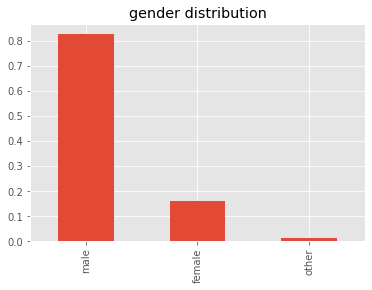

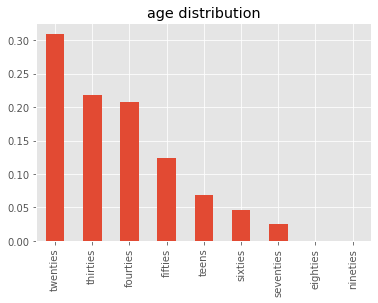

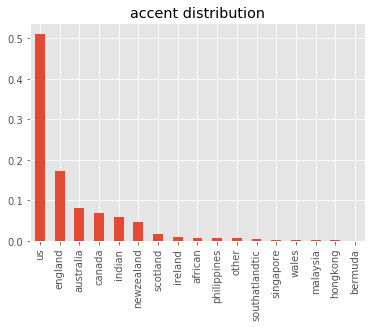

In [8]:
distribution_plotter(df,"gender")
distribution_plotter(df,"age")
distribution_plotter(df,"accent")

### Balancing the Data

In [9]:
minimum_count = 100
data_gender = df.copy()
data_age = df.copy()
data_accent = df.copy()

In [10]:
def dataBalancer(unbalanced_data,feature,floor):
    
    # Removing feature categories that are too small to predict
    counts = unbalanced_data[feature].value_counts()
    for index, value in counts.iteritems():
        if (value < floor):
            unbalanced_data = unbalanced_data[unbalanced_data[feature] != index]
    
    # Taking the largest possible sample of each feature category so that they would be balanced
    counts = unbalanced_data[feature].value_counts()
    lowest_count = min(counts)
    balanced_data = unbalanced_data.copy().head(0)
    for index, value in counts.iteritems():
        index_sample = unbalanced_data[unbalanced_data[feature] == index].sample(lowest_count)
        balanced_data = balanced_data.append(index_sample,ignore_index=True,sort=False)
    
    return balanced_data
    

In [11]:
data_gender = dataBalancer(data_gender,"gender",minimum_count)
data_age = dataBalancer(data_age,"age",minimum_count)
data_accent = dataBalancer(data_accent,"accent",minimum_count)

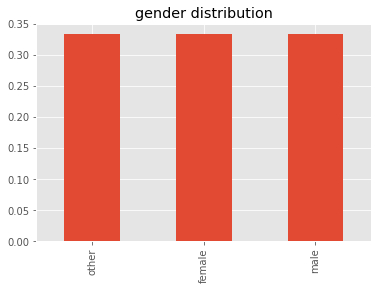

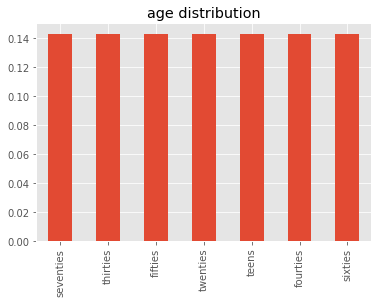

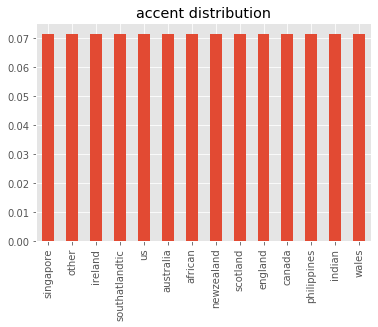

In [12]:
distribution_plotter(data_gender,"gender")
distribution_plotter(data_age,"age")
distribution_plotter(data_accent,"accent")

# Visualization

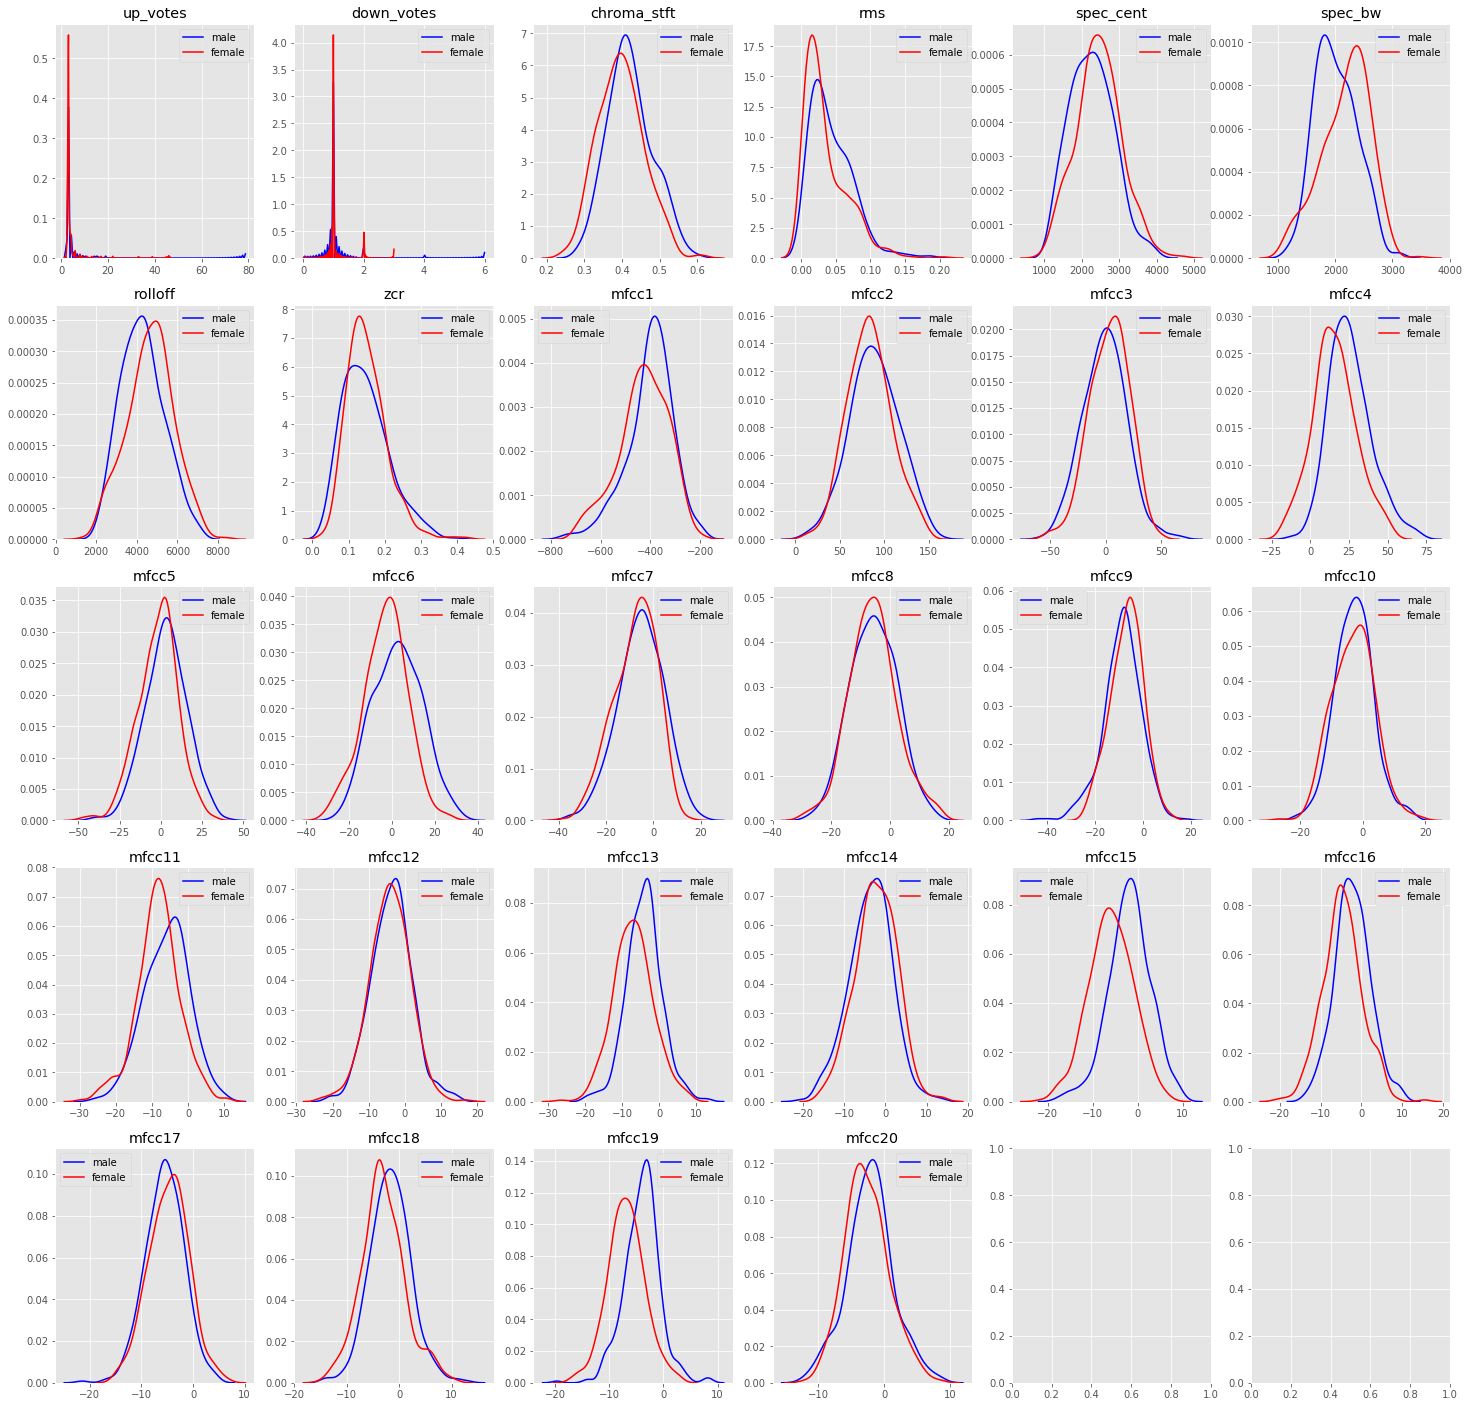

In [14]:
data = data_gender.copy()
data = data.drop(["path"],axis=1)
data = data.drop(["age"],axis=1)
data = data.drop(["accent"],axis=1)
plt.subplots(5,6,figsize=(25,25))
male_subset = data.loc[data["gender"] == "male"]
female_subset = data.loc[data["gender"]=="female"]
data = data.drop(["gender"],axis=1)
i = 1
for column in data.columns:
    plt.subplot(5,6,i)
    plt.title(column)
    sns.kdeplot(male_subset[column],color="blue",label="male")
    sns.kdeplot(female_subset[column],color="red",label="female")
    i += 1
plt.show()

# Creating some models and comparing them

In [59]:
def modelTester(name,model,features_train,features_test,target_train,target_test):
    fitted_model = model.fit(features_train,target_train)
    accuracy = accuracy_score(target_test,fitted_model.predict(features_test))
    print(name + " accuracy: " + str(accuracy))
    return fitted_model

In [60]:
#WORK IN PROGRESS - ROC (https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python)
def rocDisplayer(name,model,features_test,target_test):
    val = target_test.to_frame()
    probs = model.predict_proba(features_test)
    probs = probs[:,1]
    fpr,tpr,thresholds = metrics.roc_curve(val,probs,pos_label="male")
    roc_auc = metrics.auc(fpr, tpr)
    # ROC PLOT
    plt.title("ROC - " + name)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('TPR')
    plt.xlabel('FPR')
    plt.show()

## Gender

In [61]:
df = data_gender.copy()
df

,up_votes,down_votes,path,age,gender,accent,chroma_stft,rms,spec_cent,spec_bw,...,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20
0,2,0,data/wav_clips\common_voice_en_155285.wav,teens,male,indian,0.405800,0.065605,1866.069316,1819.464138,...,-1.595311,-1.402517,-4.867716,-1.998573,-0.895673,-4.378554,-0.727216,-2.090846,-6.372841,0.601931
1,2,0,data/wav_clips\common_voice_en_122892.wav,teens,male,us,0.407898,0.015395,3105.250982,2136.676480,...,-16.212904,-3.237628,6.772531,-4.375626,5.210238,-3.315474,-7.193130,1.675654,-7.987334,-2.542774
2,3,0,data/wav_clips\common_voice_en_137477.wav,teens,male,us,0.445015,0.045500,1735.543577,1816.397777,...,-8.164989,3.055189,-5.268633,12.328891,-4.301842,0.125693,-0.974276,-8.902769,-11.006143,4.412988
3,3,0,data/wav_clips\common_voice_en_145089.wav,twenties,male,us,0.476864,0.042893,3281.133258,2179.298358,...,-2.139441,-11.433566,-9.209378,0.036169,-1.049474,-6.268851,-6.069460,-2.946053,-6.648807,0.992723
4,2,0,data/wav_clips\common_voice_en_114730.wav,teens,male,canada,0.442731,0.053105,3014.992072,2594.752534,...,-6.393718,2.429885,-3.313617,2.166437,-0.854712,2.647914,-5.399483,-0.288038,-3.827613,-1.485247
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1234,2,1,data/wav_clips\common_voice_en_18840399.wav,teens,other,australia,0.265585,0.034384,1979.115534,1515.250105,...,-6.821582,-13.752800,-2.268732,-7.788417,-3.982523,-8.418761,0.264347,-5.725410,-4.635378,-1.873157
1235,2,0,data/wav_clips\common_voice_en_15904095.wav,teens,other,australia,0.343178,0.020356,2233.118365,2127.871824,...,-10.560452,-0.513423,-13.741282,-4.111018,-11.573733,-7.367146,-12.085252,-8.488179,-6.959930,-1.820951
1236,3,0,data/wav_clips\common_voice_en_113884.wav,twenties,other,us,0.419685,0.013390,2277.965005,2292.194616,...,-17.556025,-11.075072,-10.515748,3.568949,-12.391453,-4.442607,-7.665243,-5.913297,-11.472786,-9.886921
1237,2,0,data/wav_clips\common_voice_en_17840905.wav,thirties,other,us,0.420674,0.008845,3140.513777,2562.803901,...,-3.538838,-7.456257,-5.321738,-1.666536,-6.753817,-3.151447,-6.254244,-0.361473,-9.674783,3.108587


In [62]:
features = df.columns
features = features.drop(["up_votes","down_votes","path","age","gender","accent"])
features

Index(['chroma_stft', 'rms', 'spec_cent', 'spec_bw', 'rolloff', 'zcr', 'mfcc1',
       'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9',
       'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16',
       'mfcc17', 'mfcc18', 'mfcc19', 'mfcc20'],
      dtype='object')

In [63]:
X_train, X_test, y_train, y_test = train_test_split(df[features],df.gender,train_size=0.7)

In [64]:
#Decision tree
dct = modelTester("Decision Tree",DecisionTreeClassifier(criterion='entropy'),X_train,X_test,y_train,y_test)
dct

Decision Tree accuracy: 0.6344086021505376


DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [65]:
#Random forest
rf = modelTester("Random forest",RandomForestClassifier(n_estimators=1000),X_train,X_test,y_train,y_test)
rf

Random forest accuracy: 0.8333333333333334


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [66]:
#SVM linear
svm_l = modelTester("SVM linear",SVC(kernel='linear',probability=True),X_train,X_test,y_train,y_test)
svm_l

SVM linear accuracy: 0.6854838709677419


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [67]:
# SVM POLY
#modelTester("SVM POLY",SVC(kernel='poly', degree=2 ,gamma='auto',probability=True),X_train,X_test,y_train,y_test)

In [68]:
# SVM RBF
#modelTester("SVM RBF",SVC(kernel='rbf',gamma='auto',probability=True),X_train,X_test,y_train,y_test)

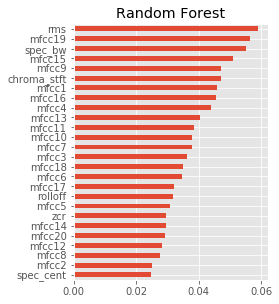

In [69]:
plt.subplots(figsize=(16, 16))
x = np.arange(-5,5,0.25)
y = np.arange(-5,5,0.25)
xx, yy = np.meshgrid(x, y)
df = pd.DataFrame({'x':xx.flatten(),'y':yy.flatten()})


feature_importances_rf = pd.Series(rf.feature_importances_, index= X_train.columns)
plt.subplot(3,4,1)
plt.title('Random Forest')
feature_importances_rf.sort_values().plot(kind='barh')

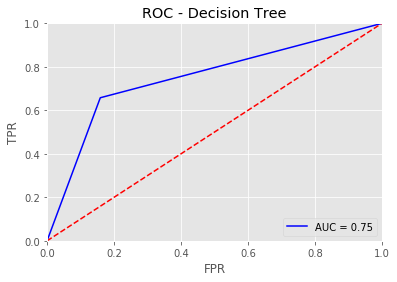

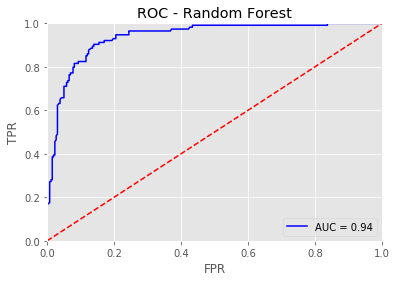

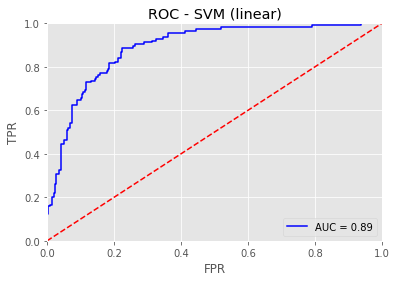

In [71]:
rocDisplayer("Decision Tree",dct,X_test,y_test)
rocDisplayer("Random Forest",rf,X_test,y_test)
rocDisplayer("SVM (linear)",svm_l,X_test,y_test)

# Accent

In [73]:
df = data_accent.copy()
df

,up_votes,down_votes,path,age,gender,accent,chroma_stft,rms,spec_cent,spec_bw,...,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20
0,2,0,data/wav_clips\common_voice_en_16047699.wav,twenties,male,us,0.391622,0.003101,2553.027201,1843.897522,...,-4.126198,-4.316660,-4.928268,-3.576022,4.478102,-1.931465,-7.661870,3.009906,-4.354860,-1.386732
1,2,0,data/wav_clips\common_voice_en_1298496.wav,teens,male,us,0.388343,0.017509,2282.969856,2317.880206,...,-8.004261,2.504765,-5.562515,-2.638762,-0.517527,2.601700,-2.557711,-3.544905,-4.789095,-4.638079
2,2,1,data/wav_clips\common_voice_en_126689.wav,teens,male,us,0.318551,0.089021,1815.378253,1597.747077,...,-0.991731,-8.309280,3.560547,-11.116528,-6.067506,-12.668531,-7.332426,-4.440709,-11.880914,0.165927
3,2,0,data/wav_clips\common_voice_en_117681.wav,fourties,male,us,0.407904,0.038112,2010.153755,1998.070032,...,-13.447212,-12.497174,-11.646801,1.330286,-7.337832,-5.948215,-6.849354,-2.799047,-8.480315,-7.040282
4,2,0,data/wav_clips\common_voice_en_164633.wav,fourties,male,us,0.392861,0.013584,1250.804429,1728.237149,...,-5.133536,-4.963606,5.043347,9.914901,3.416900,-3.720715,-6.349673,-4.646091,-2.300812,-0.817913
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,3,0,data/wav_clips\common_voice_en_136342.wav,twenties,male,wales,0.384374,0.022467,1953.209251,2054.371550,...,-6.793126,-3.971657,-10.213380,-0.029968,1.915927,-3.208296,-5.096479,-2.557650,-8.086581,-2.160982
1452,3,0,data/wav_clips\common_voice_en_136338.wav,twenties,male,wales,0.409839,0.022740,2397.091976,2132.816844,...,4.626271,2.200801,-11.926305,7.202316,-2.344884,-5.590062,-7.170095,-1.089283,-4.567224,-1.570174
1453,3,0,data/wav_clips\common_voice_en_136377.wav,twenties,male,wales,0.372438,0.018477,2326.125810,2119.090862,...,-2.588647,-2.538300,-9.009082,7.334430,-2.176220,-5.317559,-3.818541,-2.819620,-5.229694,-1.078804
1454,2,0,data/wav_clips\common_voice_en_136339.wav,twenties,male,wales,0.375651,0.016826,2084.226723,2177.908185,...,-8.308241,-3.285877,-11.966505,3.326790,-2.058838,-8.511436,-8.465044,-2.533168,-5.198150,-2.949602


In [92]:
features = df.columns
features = features.drop(["up_votes","down_votes","path","age","gender","accent"])

In [93]:
pca = PCA(n_components=3)
df_reduced = pd.DataFrame(pca.fit_transform(df[features].copy()))

In [94]:
df_reduced.insert(0,"accent",df["accent"],True)

In [95]:
df_reduced

,accent,0,1,2
0,us,276.377467,337.614435,196.230459
1,us,519.003000,-216.671796,138.465941
2,us,-975.828003,99.528032,-60.013244
3,us,-424.043399,-112.535426,-35.649179
4,us,-1881.393330,-309.752710,123.713058
...,...,...,...,...
1451,wales,-487.476449,-184.910274,21.877585
1452,wales,315.973662,-3.376454,-8.841577
1453,wales,235.438844,-29.864163,55.242480
1454,wales,-18.898978,-214.279438,101.867868


# Neural Networks

In [202]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Dense
from tensorflow.keras.optimizers import SGD

In [ ]:
def neural_network(hidden_size=5,learning_rate=0.1,momentum=0.9,weights=None):
    
    # One feature per sample
    x = Input((1,))

    # 5 hidden nodes with sigmoid as activation function
    h = Dense(hidden_size,activation='sigmoid',bias_initializer='random_uniform')(x)

    # One output with linear activation function.
    out = Dense(1,activation='linear',bias_initializer='random_uniform')(h)

    # Define a model
    model = Model(inputs=[x],outputs=[out])

    # Stochastic gradient descent with the specificed
    # learning rate and momentum.
    optimizer = SGD(lr=learning_rate,momentum=momentum)

    # Compile the model to generate the computation graph
    model.compile(optimizer=optimizer,loss='mse')
    if weights is not None:
        model.set_weights(weights)
        
    return model